# Burger number dependence

***

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import yaml
import NEMO_upwelling_postprocessing as ps

%matplotlib inline

In [2]:
plt.rcParams['font.size'] = 12

In [3]:
const = {'g': 9.81, 'f': 1.11e-4, 'rho_0': 1024, 'H': 200, 'L_R': 5e3, 'z_h': 10, 'N': 0.01}

***

## Theoretical model

[Choboter et al. 2011, JPO](https://journals.ametsoc.org/doi/full/10.1175/2011jpo4527.1)

**Assumptions**

   * Geostrophic cross-shore balance
   * Hydrostatic
   * Conservation of mass, density and PV
   
**Model**

The along-shore momentum balance

$$\frac{\partial v}{\partial t} + u\frac{\partial v}{\partial x} + w\frac{\partial v}{\partial z} + u = -\frac{\partial p}{\partial y}$$

where

$$U = \frac{\tau}{\rho_0fH} \hspace{1cm} \text{and} \hspace{1cm} T = \frac{R}{U} = \frac{\rho_0NH^2}{\tau}$$

yields the following streamfunction equation

$$\left(1 + \frac{\partial v}{\partial x}\right)\frac{\partial^2\psi}{\partial z^2} + 2\frac{\partial\rho}{\partial x}\frac{\partial^2\psi}{\partial x\partial z} - \frac{\partial\rho}{\partial z}\frac{\partial^2\psi}{\partial x^2} = 0$$

**Solution**

Choboter et al. 2011 find closed form solutions

$$
\begin{align}
\psi(x, z) & = -\frac{\alpha}{\mu}\tan^{-1}\left(\coth\mu x\tan\mu z\right) \\
v(x, z, t) & = \alpha t - x -\frac{1}{2\mu}\cosh^{-1}\left(\cosh2\mu x + \frac{\sinh^22\mu x\left(e^{2\mu\alpha t} - 1\right)}{\cosh2\mu x - \cos2\mu z}\right) \\
\rho(x, z, t) & = \frac{1}{2\mu}\cos^{-1}\left(\cos2\mu z - \frac{\sin^22\mu z\left(1 - e^{-2\mu\alpha t}\right)}{\cosh2\mu x - \cos2\mu z}\right) \\
\end{align}
$$

defined over cross-shore topography

$$z_b(x) = \frac{1}{\mu}\tan^{-1}\left(\tan\mu\tanh\mu x\right)$$

where

$$S = \tan\mu = \frac{\alpha N}{f}$$

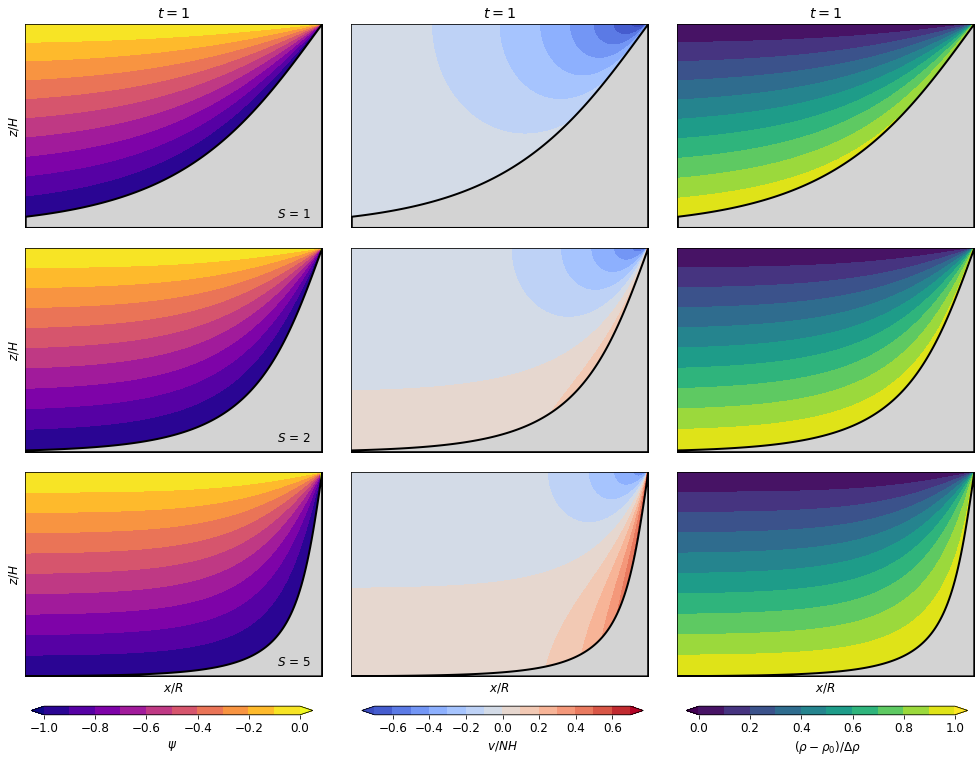

In [4]:
# -- Plot Choboter et al. 2011 solutions --
fig, axs = plt.subplots(3, 3, figsize=(17, 12), gridspec_kw={'hspace': 0.1, 'wspace': 0.1})

# Define parameters and dimensions
t, alpha = 1, 1
xi, zi = np.arange(-2, 0.01, 0.01), np.arange(-1, 0.01, 0.01)
x, z = np.meshgrid(xi, zi)

# Loop through Burger numbers
for row, S in zip(axs, [1, 2, 5]):

    # Calculate shared terms
    mu = np.arctan(S)
    denom = np.cosh(2 * mu * x) - np.cos(2 * mu * z)
    exp = 2 * mu * alpha * t

    # Calculate bathymetry
    z_b = 1 / mu * np.arctan(np.tan(mu) * np.tanh(mu * xi))

    # Calculate solutions
    psi = -alpha / mu * np.arctan(np.cosh(mu*x) / np.sinh(mu*x) * np.tan(mu*z))
    v = alpha * t - x - 1 / (2*mu) * np.arccosh(np.cosh(2*mu*x) + np.sinh(2*mu*x)**2 * (np.exp(exp) - 1) / denom)
    rho = 1 / (2*mu) * np.arccos(np.cos(2*mu*z) - np.sin(2*mu*z)**2 * (1 - np.exp(-exp)) / denom)

    # Plot solutions
    row[0].set_ylabel('$z/H$')
    row[0].text(0.85, 0.05, f'$S$ = {S:.0f}', transform=row[0].transAxes, zorder=2)
    variables, labels = [psi, v, rho], ['$\psi$', '$v/NH$', '$(\\rho - \\rho_0)/\\Delta\\rho$']
    levels, cmaps = [[-1, 0.1], [-0.7, 0.8], [0, 1.1]], ['plasma', 'coolwarm', 'viridis']
    for ax, xpos, var, label, level, cmap in zip(row, [0.13, 0.4, 0.665], variables, labels, levels, cmaps):
        c = ax.contourf(x, z, var, levels=np.arange(*level, 0.1), cmap=cmap, extend='both', zorder=0)
        ax.fill_between(xi, z_b, y2=-1, facecolor='lightgray', edgecolor='k', linewidth=2, zorder=1)
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
        if S == 1: ax.set_title('$t=1$')
        if S == 5:
            ax.set_xlabel('$x/R$')
            cax = fig.add_axes([xpos, 0.08, 0.23, 0.01])
            fig.colorbar(c, cax=cax, orientation='horizontal', label=label)

***

## Upwelling diagnostics

### Depth of upwelling

In order to find the depth of upwelling, we set the density along the bottom equal to the initial density (which is just equal to $-z$)

$$\rho(x_b, z_b, t) = \rho(x, z, 0) = -z$$

Substituting $x_b = z_b/\tan\mu$, we get the following expression for $z$

$$z = -\frac{1}{2\mu}\cos^{-1}\left\{\cos2\mu z_b - \frac{\sin^22\mu z_b\left(1 - e^{-2\alpha\mu t}\right)}{\cosh\frac{2\mu z_b}{\tan\mu} - \cos2\mu z_b}\right\}$$

In order to consider the depth of upwelling at the coast, we take the limit as $z_b \to 0$

$$Z = \lim_{z_b\to0}z = -\frac{1}{2\mu}\cos^{-1}\left\{1 - \beta\left(1 - e^{-2\alpha\mu t}\right)\right\}$$

where (using L'H&ocirc;pital's Rule)

$$\beta = \lim_{z_b\to0}\frac{\frac{\partial}{\partial z_b}\left(\sin^22\mu z_b\right)}{\frac{\partial}{\partial z_b}\left(\cosh\frac{2\mu z_b}{\tan\mu} - \cos2\mu z_b\right)} = \lim_{z_b\to0}\frac{\frac{\partial}{\partial z_b}\left(2\cos2\mu z_b\sin2\mu z_b\right)}{\frac{\partial}{\partial z_b}\left(\frac{1}{\tan\mu}\sinh\frac{2\mu z_b}{\tan\mu} + \sin2\mu z_b\right)} = \lim_{z_b\to0}\frac{2\left(\cos^22\mu z_b - \sin^22\mu z_b\right)}{\frac{1}{\tan^2\mu}\cosh\frac{2\mu z_b}{\tan\mu} + \cos2\mu z_b} = \frac{2}{\frac{1}{\tan^2\mu} + 1}$$

In dimensional terms, the depth of upwelling is predicted as

$$\boxed{\hspace{0.5cm}\frac{Z}{H} = -\frac{1}{2\tan^{-1}(S)}\cos^{-1}\left\{1 - \frac{2S^2}{1 + S^2}\left(1 - e^{-2\alpha\tan^{-1}(S)\frac{t}{T}}\right)\right\}\hspace{0.5cm}}$$

### Upwelling front advection

From the streamfunction solution $\psi$, we can obtain the cross-shore velocity $u$ along the bottom slope

$$u(x_b, z_b) = -\frac{\alpha\sinh2\mu x_b}{\cosh2\mu x_b - \cos2\mu z_b}$$

Again substituting $x_b = z_b/\tan\mu$ and taking the limit as $z_b \to 0$ (using L'H&ocirc;pital's Rule)

$$
U = \lim_{z_b\to0}\frac{-\alpha\frac{\partial}{\partial z_b}\left(\sinh\frac{2\mu z_b}{\tan\mu}\right)}{\frac{\partial}{\partial z_b}\left(\cosh\frac{2\mu z_b}{\tan\mu} - \cos2\mu z_b\right)} = \lim_{z_b\to0}\frac{-\alpha\frac{\partial}{\partial z_b}\left(\frac{1}{\tan\mu}\cosh\frac{2\mu z_b}{\tan\mu}\right)}{\frac{\partial}{\partial z_b}\left(\frac{1}{\tan\mu}\sinh\frac{2\mu z_b}{\tan\mu} + \sin2\mu z_b\right)} = \lim_{z_b\to0}\frac{-\frac{\alpha}{\tan^2\mu}\cosh\frac{2\mu z_b}{\tan\mu}}{\frac{1}{\tan^2\mu}\cosh\frac{2\mu z_b}{\tan\mu} + \cos2\mu z_b} = -\frac{\alpha}{1 + \tan^2\mu}
$$

In dimensional terms, the offshore displacement is the product of velocity and time

$$\boxed{\hspace{0.5cm}\frac{x}{L_R} = -\frac{\alpha}{1 + S^2}\frac{t}{T}\hspace{0.5cm}}$$

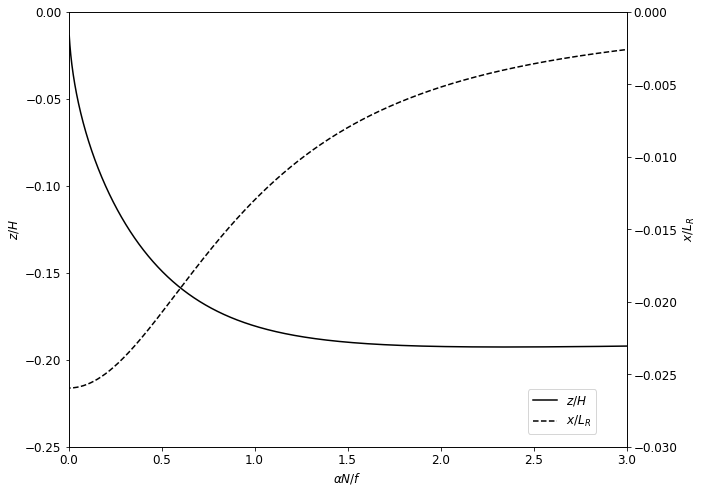

In [5]:
# -- Plot Choboter et al. 2011 upwelling diagnostics --
axs = [0, 0]
fig, axs[0] = plt.subplots(figsize=(10, 8))
axs[1] = axs[0].twinx()

# Parameters
alpha, tau, t = 1, 0.123, 86400
L = np.arange(1e3, 5e6, 10)
        
# Calculate diagnostics
S = const['N'] * const['H'] / (const['f'] * L)
T = const['rho_0'] * const['N'] * const['H']**2 / tau
exp = 1 - np.exp(-2 * alpha * np.arctan(S) * t / T)
Z = -np.arccos(1 - 2 * S**2 / (1 + S**2) * exp) / (2 * np.arctan(S))
X = -alpha / (1 + S**2) * t / T

# Plot curves
for ax, var, linestyle, ylim, label in zip(axs, [Z, X], ['-', '--'], [-0.25, -0.03], ['$z/H$', '$x/L_R$']):
    ax.plot(S, var, 'k', linestyle=linestyle, label=label)
    ax.set_xlim([0, 3])
    ax.set_ylim([ylim, 0])
    ax.set_xlabel('$\\alpha N/f$')
    ax.set_ylabel(label)
    
fig.legend(loc=[0.75, 0.12])
plt.show()

***

## Idealized model comparisons

In [6]:
# Load subdomains and sections from YAML
with open('parameters.yaml') as f: grids, _, _, _ = yaml.safe_load_all(f)

# Load netCDF results and geo files
bathy = xr.open_dataset('/data/bmoorema/MEOPAR/grid/bathymetry_201702.nc')
mask = xr.open_dataset('/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc')
path = '/data/bmoorema/results/Lake/S4d_Nconst'

# Global parameters
const = {'g': 9.81, 'f': 1.11e-4, 'rho_0': 1024, 'H': 200, 'R': 5e3, 'z_h': 10, 'N': 0.01}
hour, e1t, L = 24, 440, 50

In [7]:
# Build coastline index arrays
sections = ps.calc_coastline_indices(mask, bathy.Bathymetry)

In [8]:
# Process idealized 2-layer results
param = {
    'N': np.arange(0.01, 0.026, 0.0025),
    'u_wind': [5, 10, 15],
    'tau': [0.034, 0.123, 0.280],
}
#runs = ps.process_idealized_results_2layer(param, sections, mask, grids)

In [100]:
# Loop through run parameters and define dict fields
for N in tqdm(Nlist):
    runs[N] = {}
    for U in param['u_wind']:
        runs[N][U] = {'z_u': [], 'x_u': []}
        
        # Define and load results file
        runID = f'SalishSeaPond_S4d{U:02d}ms_N{N*1e4:04.0f}s'
        file = os.path.join(path, runID, fn)
        if os.path.exists(file):
            with xr.open_dataset(file) as data:

                # Loop through sections
                for i, j, a in zip(icoast, jindex, angle):

                    # Calculate upwelling metrics
                    z_u, x_u = calc_idealized_upwelling_metrics(
                        data, mask, hour, j, i, jsub=grids['ideal'][2], isub=grids['ideal'][0], angle=a, L=L,
                    )
                    runs[N][U]['z_u'].append(z_u)
                    runs[N][U]['x_u'].append(x_u)

In [29]:
if keys[1:]:
    print('yes')

yes


In [30]:
def loop_rec(keys):
    if keys:
        print(keys[0])
        for val in param[keys[0]]:
            loop_rec(keys[1:])

In [32]:
keys = ['N', 'u_wind']
n = len(keys)
loop_rec(keys)

N
u_wind
u_wind
u_wind
u_wind
u_wind
u_wind
u_wind


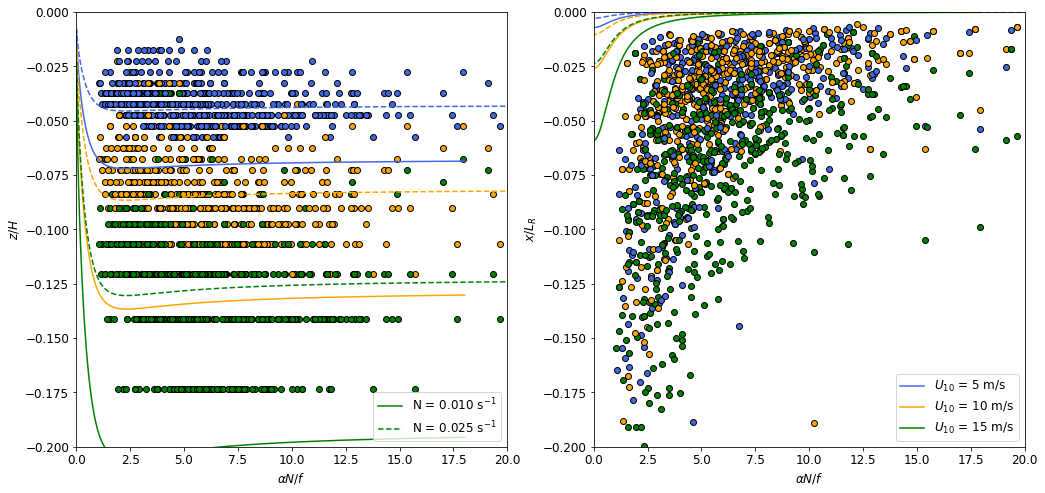

In [102]:
# -- Plot Choboter et al. 2011 upwelling diagnostics --
fig, axs = plt.subplots(1, 2, figsize=(17, 8))
for ax, ylim, ylabel in zip(axs, [-0.2, -0.2], ['$z/H$', '$x/L_R$']):
    ax.set_xlim([0, 20])
    ax.set_ylim([ylim, 0])
    ax.set_xlabel('$\\alpha N/f$')
    ax.set_ylabel(ylabel)
    
# Loop through run parameters
for N in Nlist:
    for U, tau, color in zip(param['u_wind'], param['tau'], ['royalblue', 'orange', 'g']):
            
        # Define upwelling predictor ft/W
        S = slope * N / const['f']
        L_R = N * const['H'] / const['f']

        # Plot predictions vs results
        for ax, var, scale in zip(axs, ['z_u', 'x_u'], [const['H'], L_R]):
            ax.plot(S, -np.array(runs[N][U][var]) / scale, 'ko', markerfacecolor=color)

# Constants
alpha = 0.5
t = 86400

# Variables
L = np.arange(1e3, 2e6, 10)

# Loop through wind cases
for wind, tau, color in zip([5, 10, 15], [0.034, 0.123, 0.280], ['royalblue', 'orange', 'g']):
    
    # Loop through N cases
    for N, linestyle in zip([0.01, 0.025], ['-', '--']):
        
        # Calculate diagnostics
        S = N * const['H'] / (const['f'] * L)
        T = const['rho_0'] * N * const['H']**2 / tau
        exp = 1 - np.exp(-2 * alpha * np.arctan(S) * t / T)
        Z = -np.arccos(1 - 2 * S**2 / (1 + S**2) * exp) / (2 * np.arctan(S))
        X = -1 / (1 + S**2) * t / T

        # Plot curves
        label = f'N = {N:.3f} s$^{{-1}}$' if color == 'g' else None
        axs[0].plot(S, Z, color=color, linestyle=linestyle, label=label)
        label = f'$U_{{10}}$ = {wind} m/s' if linestyle == '-' else None
        axs[1].plot(S, X, color=color, linestyle=linestyle, label=label)

# Legend
axs[0].legend(loc=4)
axs[1].legend(loc=4)
plt.show()